=== Sod convergence study at t=0.003 (using L1_rel) ===

[data250.xy] N=250, dx~0.0401205
  rho: {'L1': 0.07865549603467722, 'L2': 0.04981718401809436, 'Linf': 0.08397971170530708, 'L1_rel': 0.07865549603467722, 'L2_rel': 0.04981718401809436, 'Linf_rel': 0.08397971170530708}
  p  : {'L1': 4866.308668608918, 'L2': 4561.323413550324, 'Linf': 11968.617805064681, 'L1_rel': 0.04866308668608918, 'L2_rel': 0.04561323413550324, 'Linf_rel': 0.11968617805064681}
  Ux : {'L1': 36.44288840145396, 'L2': 38.93082624090721, 'Linf': 130.19627012454262, 'L1_rel': 0.1242570556950336, 'L2_rel': 0.13274002299656038, 'Linf_rel': 0.4439221449720622}

[data500.xy] N=500, dx~0.02002
  rho: {'L1': 0.05747732062733878, 'L2': 0.03851135027167689, 'Linf': 0.09052442817849521, 'L1_rel': 0.05747732062733878, 'L2_rel': 0.03851135027167689, 'Linf_rel': 0.09052442817849521}
  p  : {'L1': 2991.839378281405, 'L2': 3071.204899694101, 'Linf': 12457.317805064682, 'L1_rel': 0.02991839378281405, 'L2_rel': 0.03071204899694101

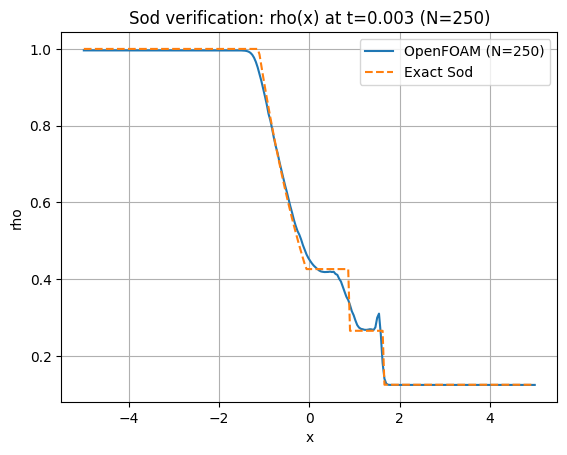

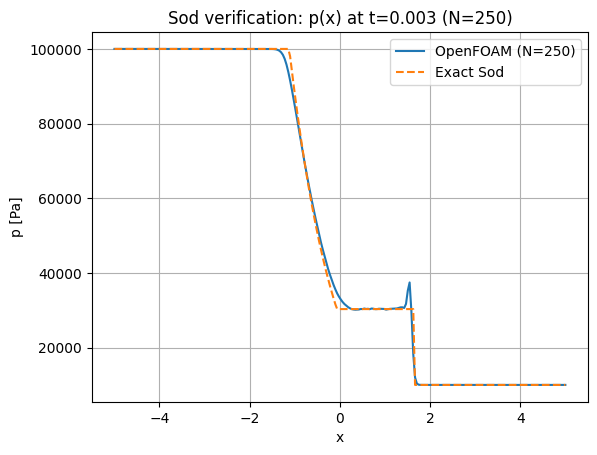

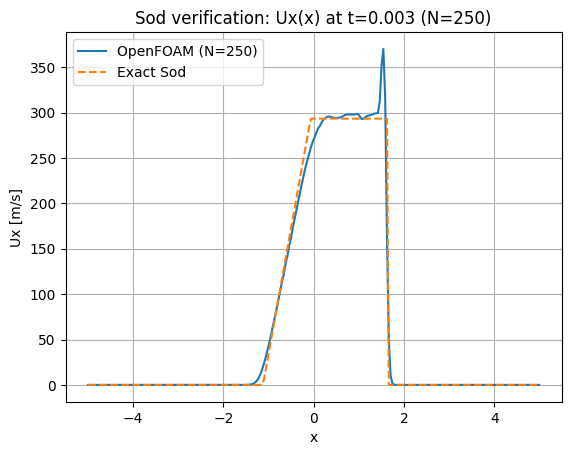

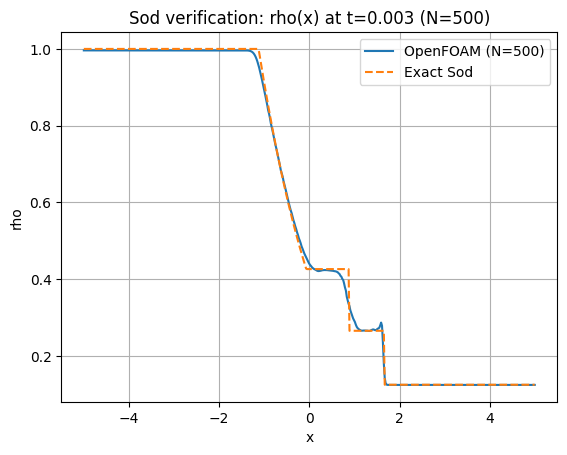

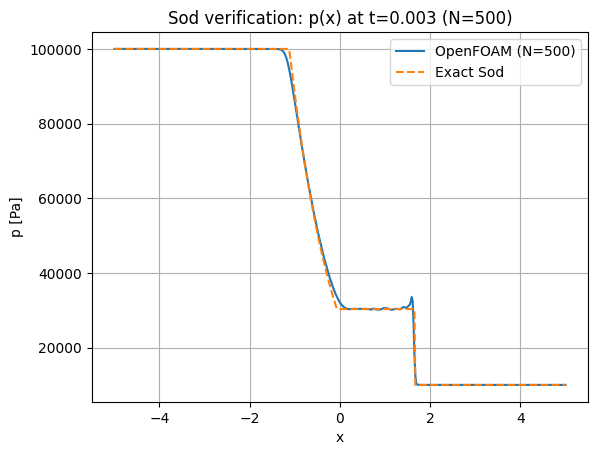

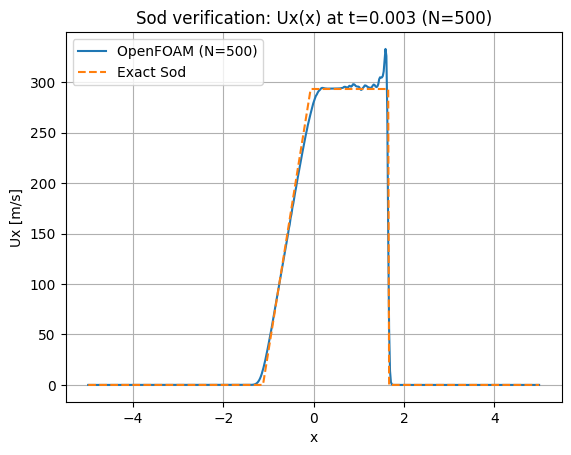

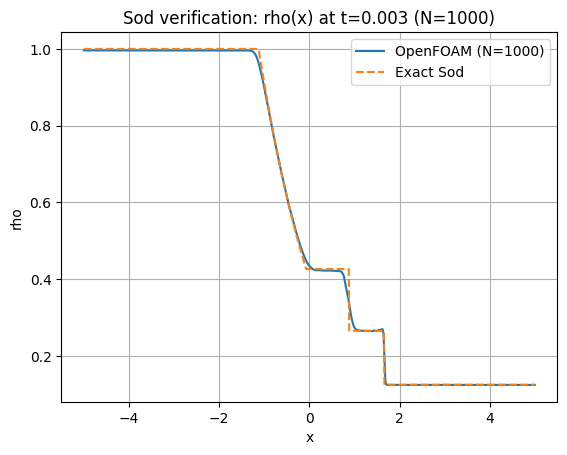

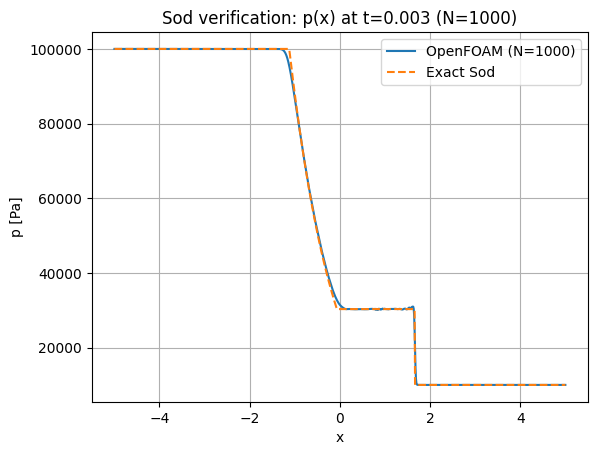

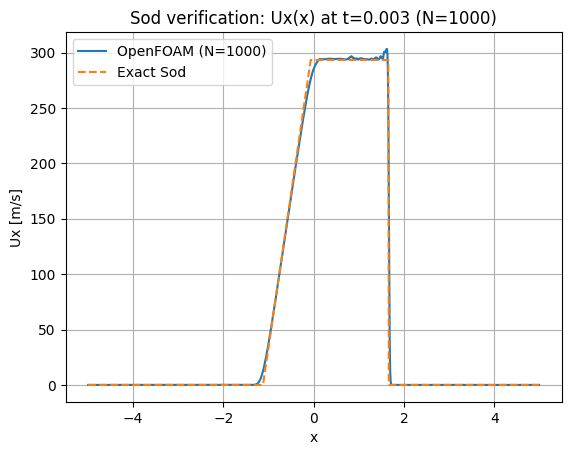

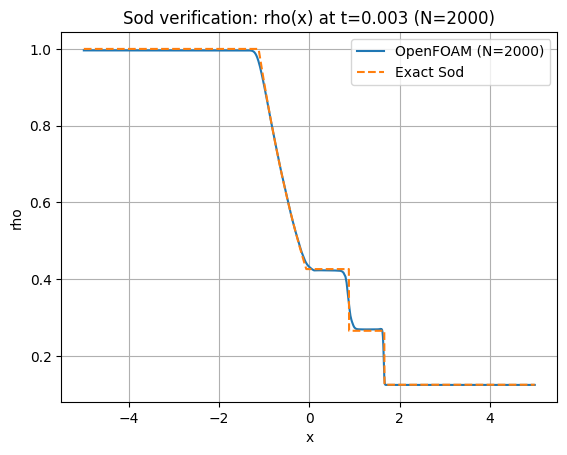

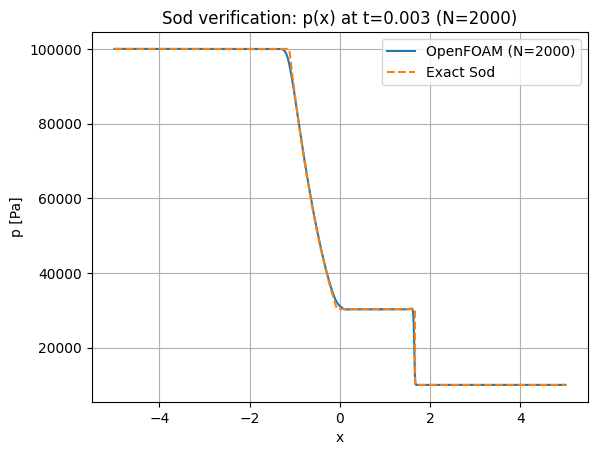

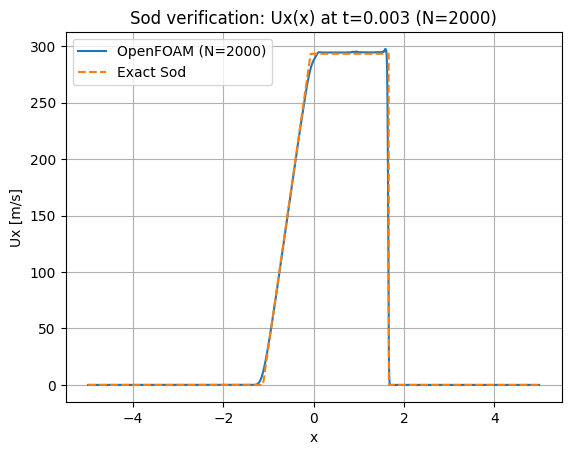

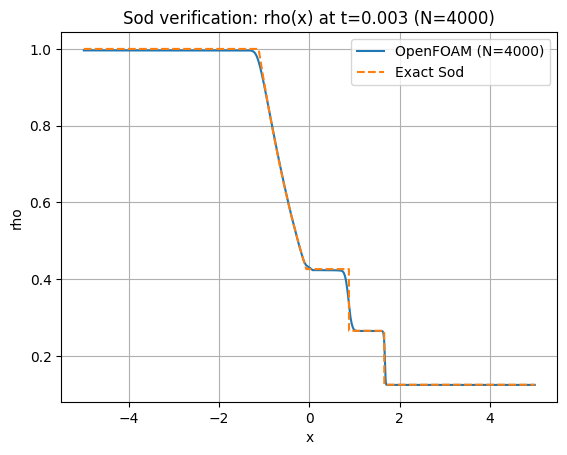

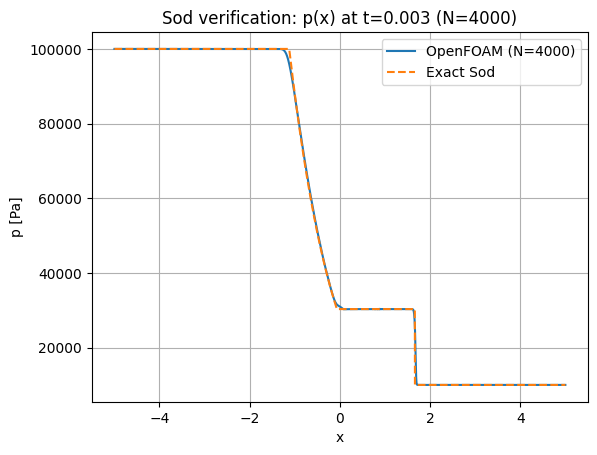

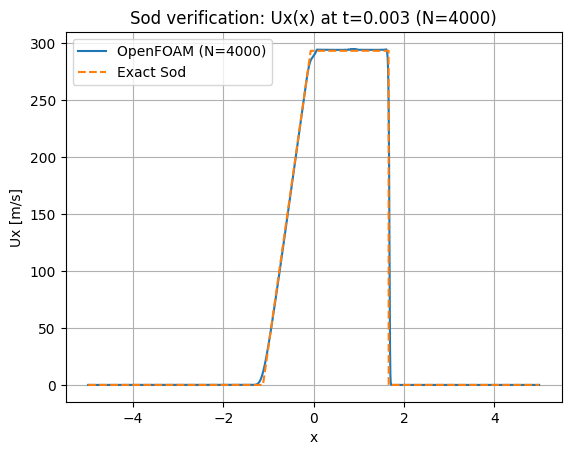

=== Estimated order (using L1_rel):  E ~ C * N^(-p) ===
rho: p = 0.289, C = 3.555e-01
p  : p = 0.479,   C = 5.954e-01
Ux : p = 0.465,   C = 1.372e+00


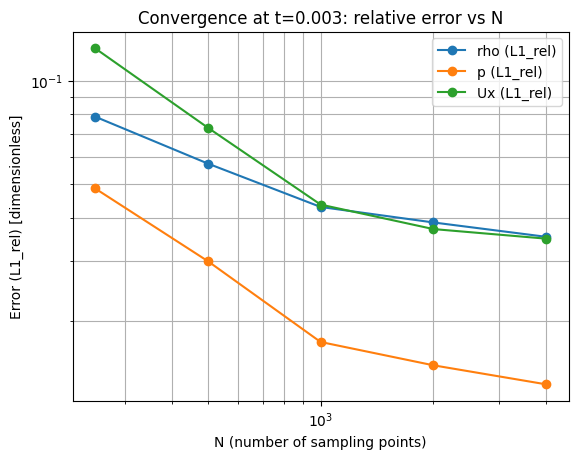

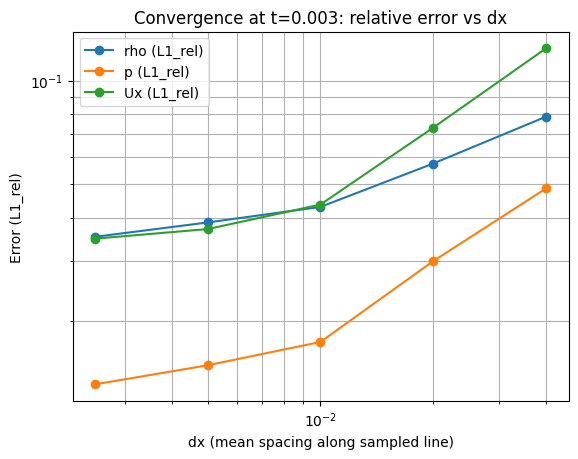

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# Sod convergence study (RELATIVE errors) for OpenFOAM samples:
#   data250.xy, data500.xy, data1000.xy, data2000.xy, data4000.xy,
#
#
# Each file columns (OpenFOAM sample raw):
#   x, rho, p, U_x, U_y, U_z   (header lines start with '#')
# ============================================================


x0     = 0.0
gamma  = 1.4
t_cmp = 0.003


# Exact Sod states (adjust if needed)
left  = dict(rho=1.0,   u=0.0, p=100000.0)
right = dict(rho=0.125, u=0.0, p=10000.0)

# Files to load (N in filename is number of sampling points)
cases = [
    ("data250.xy",    250),
    ("data500.xy",    500),
    ("data1000.xy",  1000),
    ("data2000.xy",  2000),
    ("data4000.xy",  4000),

]

# Choose norm for convergence plots: "L1_rel", "L2_rel", or "Linf_rel"
norm_key = "L1_rel"


# -----------------------------
# 1) Exact Sod (gamma-law Euler)
# -----------------------------
def _prefun(p, rho_k, p_k, gamma):
    if p <= p_k:  # rarefaction
        a_k = np.sqrt(gamma * p_k / rho_k)
        pr = p / p_k
        f  = (2 * a_k / (gamma - 1)) * (pr**((gamma - 1)/(2*gamma)) - 1)
        df = (1 / (rho_k * a_k)) * pr**(-(gamma + 1)/(2*gamma))
    else:  # shock
        A = 2 / ((gamma + 1) * rho_k)
        B = (gamma - 1) / (gamma + 1) * p_k
        f  = (p - p_k) * np.sqrt(A / (p + B))
        df = np.sqrt(A / (p + B)) * (1 - 0.5*(p - p_k)/(p + B))
    return f, df


def sod_exact(x, t, left, right, gamma=1.4, x0=0.0, newton_tol=1e-12, newton_max=200):
    rhoL, uL, pL = left["rho"], left["u"], left["p"]
    rhoR, uR, pR = right["rho"], right["u"], right["p"]

    aL = np.sqrt(gamma * pL / rhoL)
    aR = np.sqrt(gamma * pR / rhoR)

    # PVRS initial guess (Toro)
    p_pv = 0.5*(pL + pR) - 0.125*(uR - uL)*(rhoL + rhoR)*(aL + aR)
    p_star = max(1e-14, p_pv)

    # Newton solve for p*
    for _ in range(newton_max):
        fL, dfL = _prefun(p_star, rhoL, pL, gamma)
        fR, dfR = _prefun(p_star, rhoR, pR, gamma)
        g  = fL + fR + (uR - uL)
        dg = dfL + dfR
        dp = -g / dg
        p_new = p_star + dp
        if p_new <= 0:
            p_new = 1e-14
        if abs(dp) < newton_tol * max(1.0, p_new):
            p_star = p_new
            break
        p_star = p_new

    # u*
    fL, _ = _prefun(p_star, rhoL, pL, gamma)
    fR, _ = _prefun(p_star, rhoR, pR, gamma)
    u_star = 0.5*(uL + uR) + 0.5*(fR - fL)

    # Star densities
    if p_star <= pL:  # left rarefaction
        rhoL_star = rhoL * (p_star/pL)**(1/gamma)
    else:  # left shock
        num = p_star/pL + (gamma - 1)/(gamma + 1)
        den = (gamma - 1)/(gamma + 1) * p_star/pL + 1
        rhoL_star = rhoL * (num/den)

    if p_star <= pR:  # right rarefaction
        rhoR_star = rhoR * (p_star/pR)**(1/gamma)
    else:  # right shock
        num = p_star/pR + (gamma - 1)/(gamma + 1)
        den = (gamma - 1)/(gamma + 1) * p_star/pR + 1
        rhoR_star = rhoR * (num/den)

    # Wave speeds
    if p_star <= pL:  # rarefaction
        aL_star = aL * (p_star/pL)**((gamma - 1)/(2*gamma))
        SL_head = uL - aL
        SL_tail = u_star - aL_star
    else:  # shock
        qL = np.sqrt(1 + (gamma + 1)/(2*gamma) * (p_star/pL - 1))
        SL = uL - aL * qL

    if p_star <= pR:  # rarefaction
        aR_star = aR * (p_star/pR)**((gamma - 1)/(2*gamma))
        SR_head = uR + aR
        SR_tail = u_star + aR_star
    else:  # shock
        qR = np.sqrt(1 + (gamma + 1)/(2*gamma) * (p_star/pR - 1))
        SR = uR + aR * qR

    rho = np.empty_like(x, dtype=float)
    u   = np.empty_like(x, dtype=float)
    p   = np.empty_like(x, dtype=float)

    if t == 0:
        maskL = x < x0
        rho[maskL], u[maskL], p[maskL] = rhoL, uL, pL
        rho[~maskL], u[~maskL], p[~maskL] = rhoR, uR, pR
        return rho, u, p

    xi = (x - x0) / t

    for i, s in enumerate(xi):
        if s <= u_star:  # left of contact
            if p_star <= pL:  # left rarefaction
                if s <= SL_head:
                    rho[i], u[i], p[i] = rhoL, uL, pL
                elif s >= SL_tail:
                    rho[i], u[i], p[i] = rhoL_star, u_star, p_star
                else:
                    u_i = (2/(gamma + 1))*(aL + 0.5*(gamma - 1)*uL + s)
                    a_i = (2/(gamma + 1))*(aL + 0.5*(gamma - 1)*(uL - s))
                    rho_i = rhoL * (a_i/aL)**(2/(gamma - 1))
                    p_i   = pL * (a_i/aL)**(2*gamma/(gamma - 1))
                    rho[i], u[i], p[i] = rho_i, u_i, p_i
            else:  # left shock
                if s <= SL:
                    rho[i], u[i], p[i] = rhoL, uL, pL
                else:
                    rho[i], u[i], p[i] = rhoL_star, u_star, p_star
        else:  # right of contact
            if p_star <= pR:  # right rarefaction
                if s >= SR_head:
                    rho[i], u[i], p[i] = rhoR, uR, pR
                elif s <= SR_tail:
                    rho[i], u[i], p[i] = rhoR_star, u_star, p_star
                else:
                    u_i = (2/(gamma + 1))*(-aR + 0.5*(gamma - 1)*uR + s)
                    a_i = (2/(gamma + 1))*(aR - 0.5*(gamma - 1)*(uR - s))
                    rho_i = rhoR * (a_i/aR)**(2/(gamma - 1))
                    p_i   = pR * (a_i/aR)**(2*gamma/(gamma - 1))
                    rho[i], u[i], p[i] = rho_i, u_i, p_i
            else:  # right shock
                if s >= SR:
                    rho[i], u[i], p[i] = rhoR, uR, pR
                else:
                    rho[i], u[i], p[i] = rhoR_star, u_star, p_star

    return rho, u, p


# -----------------------------
# 2) Error metrics (abs + rel)
# -----------------------------
def error_metrics(num, ref, x):
    e = num - ref
    dx = np.mean(np.diff(x))
    L1 = np.sum(np.abs(e)) * dx
    L2 = np.sqrt(np.sum(e**2) * dx)
    Linf = np.max(np.abs(e))

    # relative version (simple normalization by max|ref|)
    denom = np.max(np.abs(ref)) if np.max(np.abs(ref)) > 0 else 1.0
    return dict(
        L1=L1, L2=L2, Linf=Linf,
        L1_rel=L1/denom, L2_rel=L2/denom, Linf_rel=Linf/denom
    )


def fit_order(N_list, E_list):
    """Fit E ~ C * N^{-p} => log(E)=log(C)-p log(N). Return (p,C)."""
    N = np.array(N_list, dtype=float)
    E = np.array(E_list, dtype=float)
    mask = (E > 0) & np.isfinite(E) & np.isfinite(N)
    N = N[mask]
    E = E[mask]
    if len(N) < 2:
        return np.nan, np.nan
    A = np.vstack([np.ones_like(N), -np.log(N)]).T
    y = np.log(E)
    coeff, *_ = np.linalg.lstsq(A, y, rcond=None)
    logC, p = coeff[0], coeff[1]
    return float(p), float(np.exp(logC))


# -----------------------------
# 3) Run study
# -----------------------------
results = []
print(f"=== Sod convergence study at t={t_cmp} (using {norm_key}) ===\n")

for fname, N in cases:
    data = np.loadtxt(fname, comments="#")
    x_of   = data[:, 0]
    rho_of = data[:, 1]
    p_of   = data[:, 2]
    ux_of  = data[:, 3]

    rho_ex, u_ex, p_ex = sod_exact(x_of, t_cmp, left, right, gamma=gamma, x0=x0)

    err_rho = error_metrics(rho_of, rho_ex, x_of)
    err_p   = error_metrics(p_of,   p_ex,   x_of)
    err_u   = error_metrics(ux_of,  u_ex,   x_of)

    dx = float(np.mean(np.diff(x_of)))

    results.append(dict(
        fname=fname, N=N, dx=dx,
        x=x_of, rho_num=rho_of, p_num=p_of, u_num=ux_of,
        rho_ex=rho_ex,  p_ex=p_ex,  u_ex=u_ex,
        err_rho=err_rho, err_p=err_p, err_u=err_u
    ))

    print(f"[{fname}] N={N}, dx~{dx:.6g}")
    print("  rho:", {k: float(v) for k, v in err_rho.items()})
    print("  p  :", {k: float(v) for k, v in err_p.items()})
    print("  Ux :", {k: float(v) for k, v in err_u.items()})
    print()


# -----------------------------
# 4) Overlay plots for each dataset (rho, p, Ux)
# -----------------------------
for r in results:
    N = r["N"]

    plt.figure()
    plt.plot(r["x"], r["rho_num"], label=f"OpenFOAM (N={N})")
    plt.plot(r["x"], r["rho_ex"], "--", label="Exact Sod")
    plt.xlabel("x"); plt.ylabel("rho")
    plt.title(f"Sod verification: rho(x) at t={t_cmp} (N={N})")
    plt.grid(True); plt.legend(); plt.show()

    plt.figure()
    plt.plot(r["x"], r["p_num"], label=f"OpenFOAM (N={N})")
    plt.plot(r["x"], r["p_ex"], "--", label="Exact Sod")
    plt.xlabel("x"); plt.ylabel("p [Pa]")
    plt.title(f"Sod verification: p(x) at t={t_cmp} (N={N})")
    plt.grid(True); plt.legend(); plt.show()

    plt.figure()
    plt.plot(r["x"], r["u_num"], label=f"OpenFOAM (N={N})")
    plt.plot(r["x"], r["u_ex"], "--", label="Exact Sod")
    plt.xlabel("x"); plt.ylabel("Ux [m/s]")
    plt.title(f"Sod verification: Ux(x) at t={t_cmp} (N={N})")
    plt.grid(True); plt.legend(); plt.show()


# -----------------------------
# 5) Convergence plots + order (RELATIVE)
# -----------------------------
N_list  = [r["N"]  for r in results]
dx_list = [r["dx"] for r in results]

rho_err = [float(r["err_rho"][norm_key]) for r in results]
p_err   = [float(r["err_p"][norm_key])   for r in results]
u_err   = [float(r["err_u"][norm_key])   for r in results]

p_rho, C_rho = fit_order(N_list, rho_err)
p_p,   C_p   = fit_order(N_list, p_err)
p_u,   C_u   = fit_order(N_list, u_err)

print(f"=== Estimated order (using {norm_key}):  E ~ C * N^(-p) ===")
print(f"rho: p = {p_rho:.3f}, C = {C_rho:.3e}")
print(f"p  : p = {p_p:.3f},   C = {C_p:.3e}")
print(f"Ux : p = {p_u:.3f},   C = {C_u:.3e}")

plt.figure()
plt.loglog(N_list, rho_err, "o-", label=f"rho ({norm_key})")
plt.loglog(N_list, p_err,   "o-", label=f"p ({norm_key})")
plt.loglog(N_list, u_err,   "o-", label=f"Ux ({norm_key})")
plt.xlabel("N (number of sampling points)")
plt.ylabel(f"Error ({norm_key}) [dimensionless]")
plt.title(f"Convergence at t={t_cmp}: relative error vs N")
plt.grid(True, which="both")
plt.legend()
plt.show()

plt.figure()
plt.loglog(dx_list, rho_err, "o-", label=f"rho ({norm_key})")
plt.loglog(dx_list, p_err,   "o-", label=f"p ({norm_key})")
plt.loglog(dx_list, u_err,   "o-", label=f"Ux ({norm_key})")
plt.xlabel("dx (mean spacing along sampled line)")
plt.ylabel(f"Error ({norm_key})")
plt.title(f"Convergence at t={t_cmp}: relative error vs dx")
plt.grid(True, which="both")
plt.legend()
plt.show()
